# TSFresh exploration

In [2]:
from tsfresh import select_features, extract_relevant_features, extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from get_processed_data import get_processed_data, get_train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.transformers import RelevantFeatureAugmenter
from sklearn.metrics import classification_report
import numpy as np


In [3]:
train_test_split  = get_train_test_split(
  'malte', 60 * 10, 60 * 5 # 5 second window, 2s overlap
)

In [4]:

ts_train = []
y_train = pd.Series() # 0 = not hard, 1 = hard
i = 0

ts_test = []
y_test = pd.Series() # 0 = not hard, 1 = hard


for split_i, split in enumerate(train_test_split):
  for difficulty, windows in split.items():
    for window in windows:
      data  = pd.DataFrame(window)
      data = data.drop("PacketCounter", axis=1)
      data["id"] = i
      if split_i == 0:
        ts_train.append(data)
        y_train[i] = difficulty == "hard"
      else:
        ts_test.append(data)
        y_test[i] = difficulty == "hard"
      i += 1

df_ts_train = pd.concat(ts_train)
df_ts_test = pd.concat(ts_test)


In [5]:
X_test = pd.DataFrame(index=y_test.index)
X_train = pd.DataFrame(index=y_train.index)

In [6]:
ppl = Pipeline([
            ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='SampleTimeFine', column_kind=None, column_value=None, n_jobs=2, default_fc_parameters=EfficientFCParameters())),
            ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=3)),
            ])
ppl.set_params(augmenter__timeseries_container=df_ts_train)
ppl.fit(X_train, y_train)

Feature Extraction: 100%|██████████| 10/10 [06:13<00:00, 37.35s/it]
/Users/malte/Developer/data-science-for-wearables/.venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Quat_W__query_similarity_count__query_None__threshold_0.0'
 'Quat_X__query_similarity_count__query_None__threshold_0.0'
 'Quat_Y__query_similarity_count__query_None__threshold_0.0'
 'Quat_Z__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_X__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_Y__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_Z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id',
                                          column_sort='SampleTimeFine',
                                          default_fc_parameters={'abs_energy': None,
                                                                 'absolute_maximum': None,
                                                                 'absolute_sum_of_changes': None,
                                                                 'agg_autocorrelation': [{'f_agg': 'mean',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'median',
                                                                                          'maxlag': 40},
                                                                                         {'f_agg': 'var',
                                                                                          'maxlag': 40}],
                                                                 'agg_linear_trend': [{'attr': 'rvalue',
                                                                                       'chunk_...
599        99985333  0.428276  0.577555 -0.507596  0.474725   0.763143   

     FreeAcc_Y  FreeAcc_Z   id  
0    -0.214065   0.148417    0  
1    -0.373040  -0.007256    0  
2    -0.459667  -0.135375    0  
3    -0.452044  -0.139472    0  
4    -0.495046   0.041724    0  
..         ...        ...  ...  
595  -0.885030  -1.184657  276  
596  -0.294507  -1.662996  276  
597  -0.116020  -1.750492  276  
598  -0.285981  -1.669187  276  
599  -0.115271  -1.190081  276  

[166200 rows x 9 columns])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=3))])

In [8]:
import os
import pickle
try:
    os.makedirs("models/RandomForestBalanced")
except FileExistsError:
    pass

with open(f"models/RandomForestBalanced/ws600_o300", "wb") as f:
    pickle.dump(ppl, f)


In [118]:
# with open(f"models/RandomForestBalanced/ws600_o300", "rb") as f:
#     ppl_unbalanced = pickle.load(f)

In [10]:
# ppl_unbalanced.set_params(augmenter__n_jobs=1)
ppl.set_params(augmenter__timeseries_container=df_ts_test)
y_pred = ppl.predict(X_test)

Feature Extraction: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


In [12]:
feature_names = ppl.named_steps['augmenter'].feature_selector.relevant_features
feature_names

['FreeAcc_Z__quantile__q_0.2',
 'FreeAcc_Z__quantile__q_0.3',
 'FreeAcc_Z__quantile__q_0.4',
 'FreeAcc_Z__range_count__max_1__min_-1',
 'FreeAcc_Z__quantile__q_0.9',
 'FreeAcc_Y__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"',
 'FreeAcc_Z__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
 'FreeAcc_X__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"',
 'FreeAcc_X__range_count__max_1__min_-1',
 'FreeAcc_X__quantile__q_0.8',
 'FreeAcc_Y__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
 'FreeAcc_Y__quantile__q_0.9',
 'FreeAcc_Y__range_count__max_1__min_-1',
 'FreeAcc_Z__quantile__q_0.1',
 'FreeAcc_X__quantile__q_0.9',
 'FreeAcc_Y__quantile__q_0.2',
 'FreeAcc_Z__count_above__t_0',
 'FreeAcc_Z__range_count__max_0__min_-1000000000000.0',
 'FreeAcc_Z__range_count__max_1000000000000.0__min_0',
 'FreeAcc_Z__count_below__t_0',
 'FreeAcc_X__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
 'FreeAcc_Z__change_quantiles__f_agg_"var"__isabs

In [54]:
importances = ppl.named_steps['classifier'].feature_importances_
feature_names = ppl.named_steps['augmenter'].feature_selector.relevant_features

std = np.std([tree.feature_importances_ for tree in ppl_.named_steps['classifier'].estimators_], axis=0)

In [13]:
len(ppl.named_steps['augmenter'].feature_selector.relevant_features)

948

In [28]:
ppl_unbalanced.named_steps['augmenter'].__dict__

{'filter_only_tsfresh_features': True,
 'default_fc_parameters': None,
 'kind_to_fc_parameters': None,
 'column_id': 'id',
 'column_sort': 'SampleTimeFine',
 'column_kind': None,
 'column_value': None,
 'timeseries_container':      SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  FreeAcc_X  \
 0                 0 -0.634064 -0.305900  0.667268 -0.243187   0.897042   
 1             16667 -0.634288 -0.308343  0.665901 -0.243266   1.185700   
 2             33334 -0.634115 -0.311293  0.664682 -0.243294   1.388625   
 3             50001 -0.634039 -0.314479  0.663143 -0.243595   1.238289   
 4             66668 -0.633950 -0.317556  0.661447 -0.244443   1.082093   
 ..              ...       ...       ...       ...       ...        ...   
 595       134919365 -0.081774  0.781755  0.042070  0.616779  -0.349715   
 596       134936032 -0.073356  0.786193  0.046771  0.611838   0.480141   
 597       134952699 -0.066667  0.789012  0.049356  0.608764   0.665425   
 598       134969366 -0.

In [92]:
forest_importances.sort_values( ascending=False)

FreeAcc_X__quantile__q_0.7                                                  0.027522
FreeAcc_Z__quantile__q_0.2                                                  0.025254
FreeAcc_X__range_count__max_1__min_-1                                       0.023475
FreeAcc_Z__quantile__q_0.9                                                  0.016934
FreeAcc_Z__quantile__q_0.3                                                  0.015547
                                                                              ...   
Quat_Y__longest_strike_above_mean                                           0.000000
Quat_X__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2          0.000000
Quat_X__fourier_entropy__bins_10                                            0.000000
FreeAcc_X__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"    0.000000
Quat_Y__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0          0.000000
Length: 984, dtype: float64

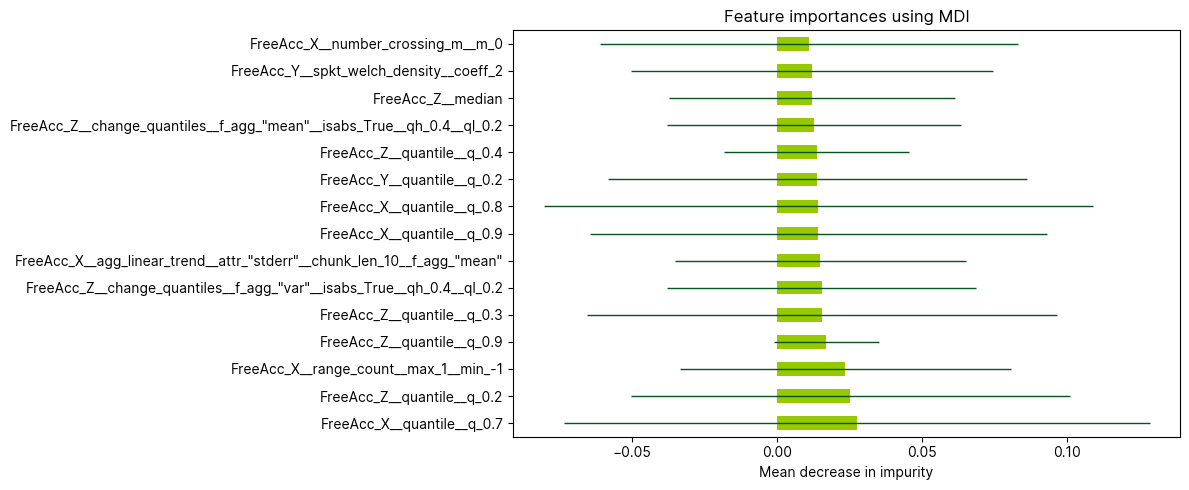

In [116]:
# import pandas as pd
import matplotlib.pyplot as plt

feature_names = ppl_unbalanced.named_steps['augmenter'].feature_selector.relevant_features

forest_importances = pd.Series(importances, index=feature_names)

sorted_feature_importances = forest_importances.sort_values(ascending=False)[:15]


# only show the 10 most important features
# forest_importances = forest_importances[:10]
# std = std[:10]
#

# 


fig, ax = plt.subplots(
  figsize=(12, 5)

)



# sorted_feature_importances.plot.bar(yerr=std[:15], ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")


# make horizontal bar plot, error bar color #085420
sorted_feature_importances.plot.barh(xerr=std[:15], ax=ax, color="#97C900", error_kw=dict(ecolor="#085420", lw=1))
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")

fig.tight_layout()



# font inter
plt.rc('font', family='Inter')

fig.savefig("exports/feature_importances_rf.png", dpi=300)

plt.show()

In [63]:
from sklearn.inspection import permutation_importance

forest = ppl_unbalanced.named_steps['classifier']
y_test = y_test

ppl_unbalanced.named_steps['augmenter'].timeseries_container = df_ts_test

ppl_unbalanced.set_params(augmenter__timeseries_container=df_ts_test)
# y_pred_unbalanced = ppl_unbalanced.predict(X_test_unbalanced)


X_test = ppl_unbalanced.named_steps['augmenter'].transform(X_test_unbalanced)




result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


In [78]:
forest_importances_sorted = forest_importances

In [83]:
forest_importances_sorted = forest_importances_sorted.sort_values(ascending=False)
forest_importances_sorted

FreeAcc_Z__quantile__q_0.2                                                0.000000
FreeAcc_Z__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"    0.000000
FreeAcc_Z__range_count__max_1000000000000.0__min_0                        0.000000
FreeAcc_Z__quantile__q_0.4                                                0.000000
FreeAcc_Z__range_count__max_1__min_-1                                     0.000000
                                                                            ...   
FreeAcc_X__number_crossing_m__m_0                                        -0.006061
FreeAcc_X__friedrich_coefficients__coeff_2__m_3__r_30                    -0.015152
FreeAcc_X__range_count__max_1__min_-1                                    -0.021212
FreeAcc_Z__quantile__q_0.9                                               -0.024242
FreeAcc_Z__quantile__q_0.3                                               -0.027273
Length: 984, dtype: float64

/var/folders/5t/xy_r0j293ms_d5q2cqn75l8w0000gn/T/ipykernel_15603/221873913.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


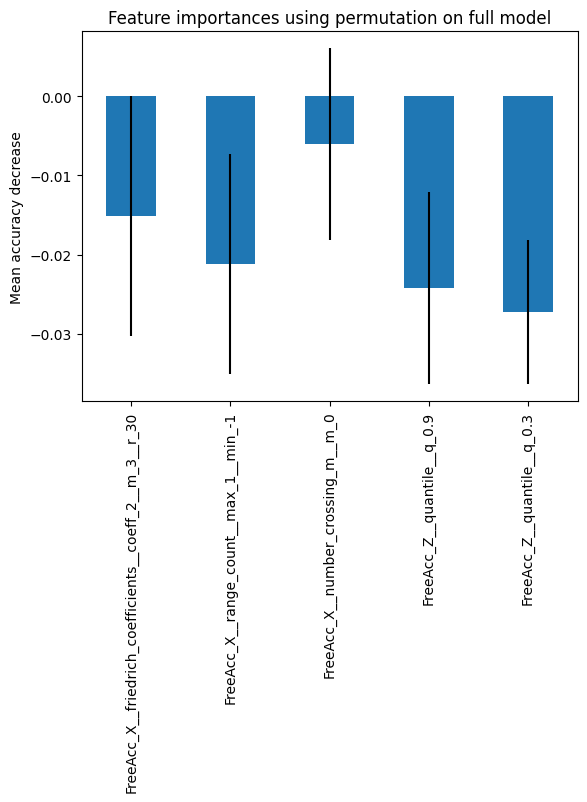

In [75]:
ig, ax = plt.subplots()

# show only 10 most important features
# f_imp = forest_importances[:40]
# imp_std = result.importances_std[:40]


# forest_importances.plot.bar(yerr=imp_std, ax=ax)

forest_importances_sorted[:5].plot.bar(yerr=importances_std_sorted, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_unbalanced))
print("Balanced Accuracy:",balanced_accuracy_score(y_test, y_pred_unbalanced))
print(confusion_matrix(y_test, y_pred_unbalanced))

NameError: name 'y_pred_unbalanced' is not defined

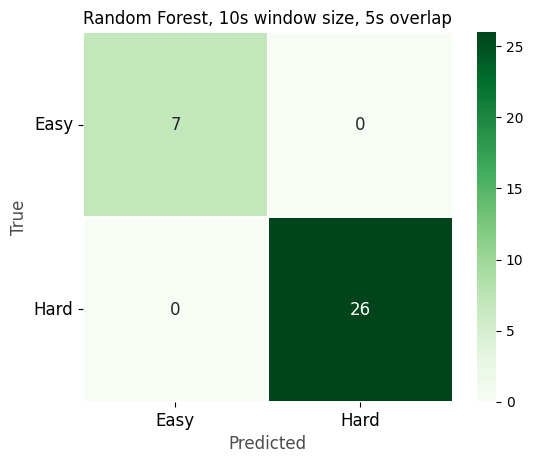

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# plot confusion matrix

# matrix = confusion_matrix(y_test, y_pred_unbalanced)
# matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

matrix = [[7, 0], 
          [0, 26]]
# matrix = [[30, 19], 
#           [26, 113]]

# Build the plot
plt.figure()
# sns.set_theme(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Greens, linewidths=0.2, fmt='g', square=True)

#fontsize
plt.yticks(fontsize=12)

# increase spacing

# Add labels to the plot
class_names = ['Easy', 'Hard']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0, fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=12)
plt.xlabel('Predicted', fontsize=12, alpha=0.7)
plt.ylabel('True', fontsize=12, alpha=0.7)
plt.title('Random Forest, 10s window size, 5s overlap')
plt.savefig('exports/confusion_matrix_rf_ws600_o300.png', dpi=300)
plt.show()


In [13]:
print(classification_report(y_test, y_pred_unbalanced))

              precision    recall  f1-score   support

       False       0.88      1.00      0.93         7
        True       1.00      0.96      0.98        26

    accuracy                           0.97        33
   macro avg       0.94      0.98      0.96        33
weighted avg       0.97      0.97      0.97        33

